# Debt Market Model

$$
\Delta{t} = t_{k+1} - t_{k}\\
{Q}_{k+1} = {Q}_k + v_1 - v_2 - v_3\\
{D_1}_{k+1} = {D_1}_k + u_1 - u_2 - u_3\\
w_3 = u_3 \cdot \frac{w_2}{u_2}\\
w_1 = [(1+\beta_k)^{\Delta{t}}-1]({D_1}_k+{D_2}_k)\\
{D_2}_{k+1} = {D_2}_k + w_1 - w_2 - w_3\\
{R}_{k+1} = {R}_k + w_2\\
$$

<center>
<img src="./diagrams/debt_dynamics.png"
     alt="Debt dynamics"
     style="width: 60%" />
</center>

<center>
<img src="./diagrams/apt_model.png"
     alt="APT model"
     style="width: 60%" />
</center>

## First phase
* Debt market state -> ETH price changes (exogenous) -> exogenous u,v -> endogenous w -> mutates system state

## Second phase
* APT model, arbitragers act -> u,v activity (to remove diversifiable risk) -> results in change to both debt market and secondary market -> stability controller updates redemption rate and price

## Current Model

1. Historically driven ETH price, locks, and draws (eventually to be driven by APT model)
2. Endogenous liquidation and closing of CDPs
3. Debt market state

# Notes

## Resources
* https://github.com/BlockScience/reflexer/blob/next-steps/next_steps.MD
* https://community-development.makerdao.com/en/learn/vaults/liquidation/

* Close CDPs along debt age distribution around 3 months
* How many CDPs are opened daily?
* How are CDPs closed?
* Assumption: opened vs. topped up CDP e.g. ETH price drops, v1 + u1 increase
  * Rate of change of ETH price, make better assumption about new CDP vs top up
  * Break down daily v1/u1 data into multiple CDPs/top ups based on assumption
  * Extreme events -> indicates top up of existing CDP (one that's fallen below certain liquidation ratio)
  
* Large to small CDP liquidation: 50/50 - 2000/1000 at start of 2019
* 1000 to 2000 active CDPs
* 300% average collat ratio

See [Maker network report](https://www.placeholder.vc/blog/2019/3/1/maker-network-report)

> Towards the end of 2018,collateralization   spiked   to   nearly   400%, perhaps  due  to  heightened  risk-aversion  on the  part  of  CDP  holders,but  has  recently declined  back  to  ~270%,  slightly  under  the system’s average of ~300%.

> As  shown  in  Figure  2A, the average non-empty  CDP  declined  from  above $60Kdaiin  debtat  the  start  of  2018  to  just  over $30Kat  the  start  of  2019.Meanwhile,  the medianCDPby debtgrew from under $500in  debtat  the  start  of  the  year,  reaching around $4Kin   August,before   declining sharply to around$500by early February.

> The  significant delta between  mean and  mediandebts highlights thepower  law distribution acrossCDPs. While small CDPs dominate  by number—with  over  80%  of CDPsdrawingless  than $10K  of  dai—they representjust  over 3%  oftotal debt  in  the system.  On  the  other  end  of  the  spectrum, about 90CDPs (less  than  4%by  number) individually have  more  than $100Kin  dai outstanding,  representing nearly  84%  of  all debt  in  the  system.

> Such concentrationin     debtcan     be problematicfor dai supply.For example, four of the six periodsof dai contractiondiscussed in the previous section were associated with CDPs that  had  over$500K  in  debtbeing liquidated. For  example,  CDP  614 hadover 4.3  million in  debt at  liquidation  on  March 18th, accountingfor much of the contraction in outstanding     dai at     the     time. More dramatically,  the  liquidation  of CDPs  3228 and   3164,on   November   20thand   25threspectively,amounted  to  a  contraction  of over $10.7M in dai, making these two CDPs the primary culprits of thelargest contraction in   daisupplyof2018(i.e.   mid-to-late November as showninFigure 1B).

# Imports

In [1]:
#%pip install git+https://github.com/danlessa/cadCAD@no_deepcopy

In [2]:
#%pip show cadCAD

In [3]:
from shared import *

In [4]:
import numpy as np
import datetime as dt
import pandas as pd

# Historic MakerDAO Dai debt market activity

In [5]:
debt_market_df = pd.read_csv('market_model/data/debt_market_df.csv', index_col='date', parse_dates=True)
debt_market_df

,rho_star,beta,p,Q,v_1,v_2 + v_3,u_1,u_2 + u_3,u_2,w_2,u_3,w_3,w_2 + w_3,D_1,D_2,w_1,D,C_star,p_star,p_ema_10
date,,,,,,,,,,,,,,,,,,,,
2017-12-18,736.004090,0.005,1.017605,2.425662e+03,2526.662000,101.000000,5.953420e+05,4.594384e+01,1.000000e+01,0.000006,35.943840,0.000023,0.000029,5.952961e+05,0.000000e+00,0.000000,5.952961e+05,1.785297e+06,1,1.008573
2017-12-19,832.236972,0.005,1.003376,6.240431e+03,3821.320309,6.550995,1.379832e+06,3.539448e+04,3.536748e+04,0.455885,27.000000,0.000348,0.456233,1.939733e+06,2.604943e+01,26.505662,1.939759e+06,5.193518e+06,1,1.008573
2017-12-20,810.287507,0.005,1.012972,1.418307e+04,8066.895210,124.255903,2.676383e+06,5.022518e+05,5.014128e+05,0.178879,839.000000,0.000299,0.179179,4.113865e+06,8.208488e+01,56.214632,4.113947e+06,1.149236e+07,1,1.008573
2017-12-21,837.231080,0.005,1.025738,1.564473e+04,1471.742069,10.080000,8.053550e+05,4.978271e+04,4.978271e+04,1.158909,0.000000,0.000000,1.158909,4.869437e+06,1.474660e+02,66.539983,4.869584e+06,1.309826e+07,1,1.008573
2017-12-22,689.014990,0.005,0.972228,1.883084e+04,5316.960481,2130.848985,3.145512e+05,7.474531e+05,7.239153e+05,19.756468,23537.818000,0.642374,20.398842,4.436535e+06,1.876926e+02,60.625449,4.436723e+06,1.297473e+07,1,1.008573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,167.637314,0.125,1.021405,1.525944e+06,56696.770732,29566.578527,8.079170e+05,1.585480e+06,1.515115e+06,64257.311824,70364.380268,2984.212338,67241.524162,7.957442e+07,4.562428e+06,27167.708945,8.413685e+07,2.558052e+08,1,1.008076
2019-09-27,167.347085,0.125,1.007346,1.529959e+06,7598.158072,3582.812664,6.087607e+05,6.367461e+05,6.366783e+05,7214.430099,67.790257,0.768156,7215.198255,7.954644e+07,4.582358e+06,27145.743151,8.412880e+07,2.560342e+08,1,1.009903
2019-09-28,174.289775,0.125,1.011006,1.528450e+06,876.961579,2386.452089,2.251956e+05,1.452312e+05,1.452062e+05,492.589362,25.000000,0.084809,492.674170,7.962640e+07,4.609044e+06,27177.983765,8.423545e+07,2.663932e+08,1,1.011184


In [6]:
debt_market_df.insert(0, 'seconds_passed', 24 * 3600)
debt_market_df['cumulative_v_1'] = debt_market_df['v_1'].cumsum()

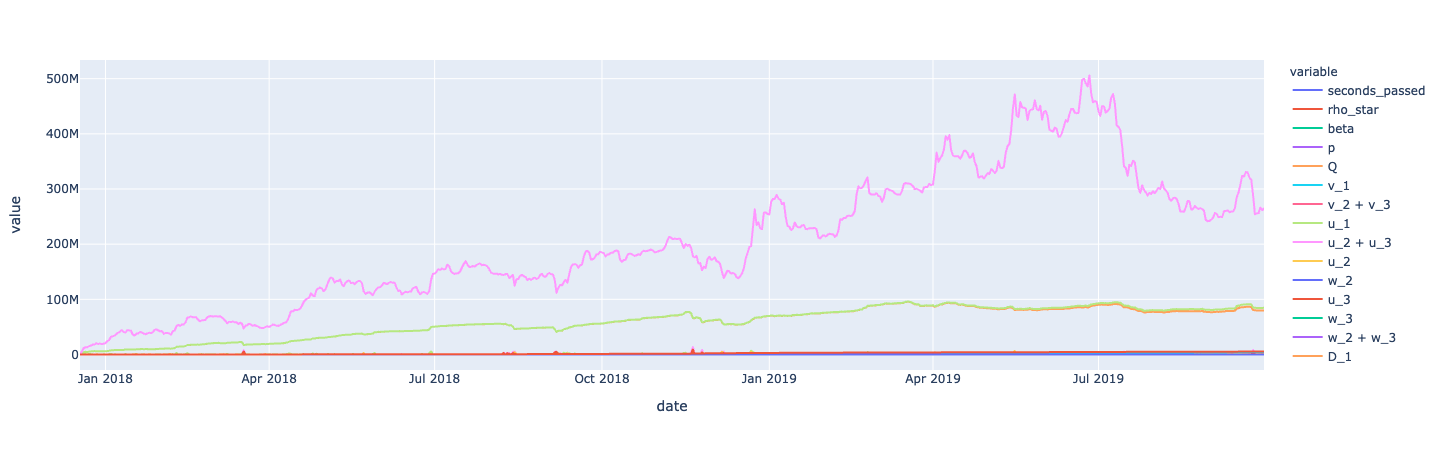

In [7]:
debt_market_df.plot()

# APT Model Setup

In [8]:
features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                    'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                    'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                    'D']

features_ml = ['beta', 'Q', 'v_1', 'v_2 + v_3', 'u_1', 'u_2', 'u_3', 'w_1', 'w_2', 'w_3', 'D']

optvars = ['u_1', 'u_2', 'v_1', 'v_2 + v_3']

historical_initial_state = {k: debt_market_df.iloc[0][k] for k in features}
historical_initial_state

{'beta': 0.005,
 'Q': 2425.6619999999994,
 'v_1': 2526.6619999999994,
 'v_2 + v_3': 101.0,
 'D_1': 595296.0830293334,
 'u_1': 595342.0268693233,
 'u_2': 10.0,
 'u_3': 35.94383999,
 'u_2 + u_3': 45.94383999,
 'D_2': 0.0,
 'w_1': 0.0,
 'w_2': 6.2764756553528835e-06,
 'w_3': 2.256006366571345e-05,
 'w_2 + w_3': 2.8836539321066332e-05,
 'D': 595296.0830293334}

In [9]:
# APT model initial feature vector

# [[1.00000000e+00 5.00000000e-03 2.42566200e+03 2.52666200e+03
#   1.01000000e+02 5.95296083e+05 5.95342027e+05 1.00000000e+01
#   3.59438400e+01 4.59438400e+01 0.00000000e+00 0.00000000e+00
#   6.27647566e-06 2.25600637e-05 2.88365393e-05 5.95296083e+05]]

# 1 1.01760484160946 1 3.86810578185312e-06 365.8127290676168 736.004090277778 0.6756295152422528 1.0004125645956772 0 1.0043275924442232

# {'u_2': 5748489.160776663, 'v_1': 23430.26903522912}

## Root function

In [10]:
import pickle

model = pickle.load(open('models/pickles/apt_debt_model_2020-11-28.pickle', 'rb'))

# ML debt model root function
def G(x, to_opt, data, constant):
    for i,y in enumerate(x):
        data[:,to_opt[i]] = y
    err = model.predict(data)[0] - constant
    return err

dpres = pickle.load(open('models/pickles/debt_market_OLS_model.pickle', 'rb'))

def G_OLS(x, to_opt, data, constant):
    for i,y in enumerate(x):
        data[:,to_opt[i]] = y
    err = dpres.predict(data)[0] - constant
    #print(f'G_OLS err: {err}')
    return err

# Global minimizer function
def glf(x, to_opt, data, constant):
    for i,y in enumerate(x):
        #print(x)
        data[:,to_opt[i]] = y
    err = model.predict(data)[0] - constant
    #print(err)
    return abs(err)

# Model Configuration

In [11]:
eth_price = pd.DataFrame(debt_market_df['rho_star'])
eth_p_mean = np.mean(eth_price.to_numpy().flatten())

mar_price = pd.DataFrame(debt_market_df['p'])
mar_p_mean = np.mean(mar_price.to_numpy().flatten())

eth_returns = ((eth_price - eth_price.shift(1))/eth_price.shift(1)).to_numpy().flatten()
eth_gross_returns = (eth_price / eth_price.shift(1)).to_numpy().flatten()

eth_returns_mean = np.mean(eth_returns[1:])

eth_p_mean, eth_returns_mean, mar_p_mean

(365.8127290676168, -0.0012148823654996293, 1.0004125645956772)

In [12]:
#eth_collateral = 2500.0
eth_price = eth_price.iloc[0] #386.71

liquidation_ratio = 1.5 # 150%
liquidation_buffer = 2
#collateral_value = eth_collateral * eth_price
target_price = 1.0
#principal_debt = collateral_value / (target_price * liquidation_ratio * liquidation_buffer)

# print(f'''
# {principal_debt * target_price}
# {collateral_value}
# ''')

In [13]:
stability_fee = (historical_initial_state['beta'] * 30 / 365) / (30 * 24 * 3600)

In [14]:
# Create a "genesis" CDP

genesis_cdp_count = 1

cdp_list = []
for i in range(genesis_cdp_count):
    cdp_list.append({
        'open': 1, # True/False == 1/0 for integer/float series
        'time': 0,
        'locked': historical_initial_state['v_1'],
        'drawn': historical_initial_state['u_1'],
        'wiped': historical_initial_state['u_2'],
        'freed': 0.0,
        'v_bitten': historical_initial_state['v_2 + v_3'],
        'u_bitten': historical_initial_state['u_3'],
        'w_bitten': historical_initial_state['w_3'],
        'dripped': 0.0
    })

cdps = pd.DataFrame(cdp_list)
cdps

,open,time,locked,drawn,wiped,freed,v_bitten,u_bitten,w_bitten,dripped
0,1,0,2526.662,595342.026869,10.0,0.0,101.0,35.94384,0.000023,0.0


In [15]:
partial_results = pd.DataFrame()
partial_results_file = 'exports/partial_results.pickle'
partial_results.to_pickle(partial_results_file)

In [16]:
initial_state = {
    'events': [],
    'cdps': cdps,
    # Loaded from exogenous parameter
    'eth_price': eth_price.iloc[0], # dollars
    # v
    'eth_collateral': historical_initial_state['Q'] * genesis_cdp_count, # Q
    'eth_locked': historical_initial_state['v_1'] * genesis_cdp_count, # v1
    'eth_freed': 0.0 * genesis_cdp_count, # v2
    'eth_bitten': historical_initial_state['v_2 + v_3'] * genesis_cdp_count, # v3
    'v_1': historical_initial_state['v_1'],
    'v_2': 0.0,
    'v_3': historical_initial_state['v_2 + v_3'],
    # u
    'principal_debt': historical_initial_state['D_1'] * genesis_cdp_count, # D1
    'rai_drawn': historical_initial_state['u_1'] * genesis_cdp_count, # u1 "minted"
    'rai_wiped': historical_initial_state['u_2'] * genesis_cdp_count, # u2
    'rai_bitten': historical_initial_state['u_3'] * genesis_cdp_count, # u3
    'u_1': historical_initial_state['u_1'],
    'u_2': historical_initial_state['u_2'],
    'u_3': historical_initial_state['u_3'],
    # w
    'w_1': historical_initial_state['w_1'],
    'w_2': historical_initial_state['w_2'],
    'w_3': historical_initial_state['w_3'],
    'accrued_interest': historical_initial_state['D_2'] * genesis_cdp_count,
    'stability_fee': stability_fee,
    'market_price': debt_market_df.iloc[0]['p'],
    'target_price': target_price, # dollars == redemption price
    'target_rate': 0 / (30 * 24 * 3600), # per second interest rate (X% per month)
    'p_expected': target_price,
}

initial_state.update(historical_initial_state)

parameters = {
    'debug': [True], # Print debug messages (see APT model)
    'raise_on_assert': [False],
    'free_memory_states': [['cdps', 'events']], #'cdps',
    #'eth_market_std': [1],
    #'random_state': [np.random.RandomState(seed=0)],
    'liquidation_ratio': [liquidation_ratio], # %
    'liquidation_buffer': [liquidation_buffer], # multiplier applied to CDP collateral by users
    'stability_fee': [lambda timestep, df=debt_market_df: stability_fee], # df.iloc[timestep].beta / (365 * 24 * 3600), # per second interest rate (1.5% per month)
    'liquidation_penalty': [0], # 0.13 == 13%
    'cdp_top_up_buffer': [2],
    # Average CDP duration == 3 months: https://www.placeholder.vc/blog/2019/3/1/maker-network-report
    # The tuning of this parameter is probably off the average, because we don't have the CDP size distribution matched yet,
    # so although the individual CDPs could have an average debt age of 3 months, the larger CDPs likely had a longer debt age.
    'average_debt_age': [3 * (30 * 24 * 3600)], # delta t (seconds)
    'eth_price': [lambda timestep, df=debt_market_df: df.iloc[timestep].rho_star],
    #'v_1': [lambda state, _state_history, df=debt_market_df: df.iloc[state['timestep']].v_1], # Driven by historical data
    #'u_1': [lambda timestep, df=debt_market_df: df.iloc[timestep].u_1], # Driven by historical data
    'seconds_passed': [lambda timestep, df=debt_market_df: df.iloc[timestep].seconds_passed],
    # 'market_price': [lambda timestep, df=debt_market_df: target_price],
    # APT model
    # **{
    #     'use_APT_ML_model': [False],
    #     'root_function': [G_OLS], # glf, G, G_OLS
    #     'features': [features], # features_ml, features
    # },
    **{
        'use_APT_ML_model': [True],
        'root_function': [glf], # glf, G, G_OLS
        'features': [features_ml], # features_ml, features
    },
    'freeze_feature_vector': [False], # Use the same initial state as the feature vector for each timestep
    'optvars': [optvars],
    'bounds': [[(xmin,debt_market_df[optvars].max()[i]) 
        for i,xmin in enumerate(debt_market_df[optvars].min())
        ]],
    'interest_rate': [1.0],
    'eth_p_mean': [eth_p_mean],
    'eth_returns_mean': [eth_returns_mean],
    'mar_p_mean': [mar_p_mean],
    # APT OLS model
    'alpha_0': [0],
    'alpha_1': [1],
    'beta_0': [1.0003953223600617],
    'beta_1': [0.6756295152422528],
    'beta_2': [3.86810578185312e-06],    
    # Controller
    'controller_enabled': [True],
    'kp': [-1.5e-6], #5e-7 #proportional term for the stability controller: units 1/USD
    'ki': [lambda control_period=3600: 0 / control_period], #-1e-7 #integral term for the stability controller: units 1/(USD*seconds)
    'partial_results': [partial_results_file],
}

# parameters = parameters.update({
#     'delta_v1': [lambda state, state_history: delta_v1(state, state_history)],
#     'market_price': [lambda timestep, df=debt_market_df: df.iloc[timestep].p]
# })

# Simulation Execution

In [17]:
SIMULATION_TIMESTEPS = len(debt_market_df) - 1 # approx. 600
MONTE_CARLO_RUNS = 1

In [18]:
from models.config_wrapper import ConfigWrapper
import models.system_model_v2 as system_model_v2

system_simulation = ConfigWrapper(system_model_v2, T=range(100), M=parameters, initial_state=initial_state)

In [19]:
from cadCAD import configs
del configs[:]

system_simulation.append()

(simulation_result, tensor_field, sessions) = run(drop_midsteps=True)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 50, 1, 47)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
p_expected terms: (1, 1.01760484160946, 1.0, 3.86810578185312e-06, 365.8127290676168, 736.004090277778, 0.6756295152422528, 1.0004125645956772, 0, 1.0043275924442232)
##### APT model run #####
Timestep: 1
[[5.00000000e-03 2.42566200e+03 2.52666200e+03 1.01000000e+02
  5.95342027e+05 1.00000000e+01 3.59438400e+01 0.00000000e+00
  6.27647566e-06 2.25600637e-05 5.95296083e+05]]
x0:  [5.95342027e+05 1.00000000e+01 2.52666200e+03 1.01000000e+02]
optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
p_expected:  1.0043275924442232
Optimizatio

In [20]:
partial_results: pd.DataFrame = pd.read_pickle(partial_results_file)
partial_results

,D,D_1,D_2,Q,accrued_interest,beta,blockheight,cdps,cumulative_time,error_star,...,u_2 + u_3,u_3,v_1,v_2,v_2 + v_3,v_3,w_1,w_2,w_2 + w_3,w_3
0,595296.083029,595296.083029,0.0,2425.662,84.572098,0.005,0.0,open time locked drawn ...,86400.0,-0.017605,...,45.94384,0.0,112461.023087,8413.287072,101.0,0.0,0.0,0.0,0.000029,0.0
1,595296.083029,595296.083029,0.0,2425.662,30654.793248,0.005,0.0,open time locked drawn...,172800.0,-0.004266,...,45.94384,0.0,166214.824176,1140.389388,101.0,0.0,0.0,0.0,0.000029,0.0
2,595296.083029,595296.083029,0.0,2425.662,42196.238694,0.005,0.0,open time locked drawn...,259200.0,0.001228,...,45.94384,0.0,166214.879005,994.681829,101.0,0.0,0.0,0.0,0.000029,0.0
3,595296.083029,595296.083029,0.0,2425.662,38194.590701,0.005,0.0,open time locked drawn...,345600.0,0.002289,...,45.94384,0.0,166074.230837,775.656724,101.0,0.0,0.0,0.0,0.000029,0.0
4,595296.083029,595296.083029,0.0,2425.662,28503.871496,0.005,0.0,open time locked draw...,432000.0,0.003305,...,45.94384,0.0,57237.497897,43.073138,101.0,0.0,0.0,0.0,0.000029,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,595296.083029,595296.083029,0.0,2425.662,463672.528841,0.005,0.0,open time locked dr...,8294400.0,-0.000584,...,45.94384,0.0,165710.491738,140869.700133,101.0,0.0,0.0,0.0,0.000029,0.0
96,595296.083029,595296.083029,0.0,2425.662,504041.733360,0.005,0.0,open time locked dr...,8380800.0,-0.000533,...,45.94384,0.0,165711.174543,140869.443404,101.0,0.0,0.0,0.0,0.000029,0.0
97,595296.083029,595296.083029,0.0,2425.662,541838.970780,0.005,0.0,open time locked dr...,8467200.0,-0.000483,...,45.94384,0.0,165713.761534,140868.950579,101.0,0.0,0.0,0.0,0.000029,0.0
98,595296.083029,595296.083029,0.0,2425.662,576990.253495,0.005,0.0,open time locked dr...,8553600.0,-0.000508,...,45.94384,0.0,165712.914649,140869.056906,101.0,0.0,0.0,0.0,0.000029,0.0


In [21]:
# Print system events e.g. liquidation assertion errors
simulation_result[simulation_result.events.astype(bool)].events.apply(lambda x: x[0])

Series([], Name: events, dtype: object)

# Simulation Analysis

In [22]:
#simulation_result = pd.concat([simulation_result, debt_market_df.reset_index()], axis=1)

simulation_result = simulation_result.assign(eth_collateral_value = simulation_result.eth_collateral * simulation_result.eth_price)

simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.target_price)
#simulation_result['historical_collateralization_ratio'] = (simulation_result.Q * simulation_result.rho_star) / (simulation_result.D_1 * simulation_result.p)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

simulation_result

,index,events,error_star,error_star_integral,market_price,blockheight,timedelta,cumulative_time,timestamp,cdps,eth_price,eth_collateral,eth_locked,eth_freed,eth_bitten,v_1,v_2,v_3,principal_debt,rai_drawn,rai_wiped,rai_bitten,u_1,u_2,u_3,accrued_interest,system_revenue,stability_fee,interest_dripped,interest_wiped,interest_bitten,w_1,w_2,w_3,target_price,target_rate,p_expected,eth_return,eth_gross_return,optimal_values,beta,Q,v_2 + v_3,D_1,u_2 + u_3,D_2,w_2 + w_3,D,simulation,subset,run,substep,timestep,eth_collateral_value,collateralization_ratio
0,0,None,0.000000,0.000000,1.017605,0,0.0,0.0,2017-12-18,None,736.004090,2.425662e+03,2.526662e+03,0.000000e+00,101.0,2526.662000,0.000000,101.0,5.952961e+05,5.953420e+05,1.000000e+01,35.94384,5.953420e+05,1.000000e+01,35.94384,0.000000,0,1.585490e-10,0,0,0,0.0,0.000006,0.000023,1.000000,0.000000e+00,1.000000,0.000000,0.0,{},0.005,2425.662,101.0,595296.083029,45.94384,0.0,0.000029,595296.083029,0,0,1,0,0,1.785297e+06,2.999007
1,20,None,-0.017605,-760.529158,1.006551,0,86400.0,86400.0,2017-12-19,None,832.236972,1.064734e+05,1.149877e+05,8.413287e+03,101.0,112461.023087,8413.287072,0.0,6.173721e+06,6.196073e+06,2.231621e+04,35.94384,2.754048e+07,2.230621e+04,0.00000,84.572098,0,1.585490e-10,0,0,0,0.0,0.000000,0.000000,1.002284,2.640726e-08,1.004328,0.130750,1.0,"{'u_1': 5600731.326823772, 'u_2': 22306.209661...",0.005,2425.662,101.0,595296.083029,45.94384,0.0,0.000029,595296.083029,0,0,1,20,1,8.861110e+07,14.320238
2,40,None,-0.004266,-1633.833664,1.001610,0,86400.0,172800.0,2017-12-20,None,810.287507,2.715478e+05,2.812025e+05,9.553676e+03,101.0,166214.824176,1140.389388,0.0,1.330333e+07,1.332613e+07,2.276036e+04,35.94384,4.885051e+07,4.441531e+02,0.00000,30654.793248,0,1.585490e-10,0,0,0,0.0,0.000000,0.000000,1.002839,6.399462e-09,1.000560,-0.026374,1.0,"{'u_1': 7130056.761575813, 'u_2': 444.15310103...",0.005,2425.662,101.0,595296.083029,45.94384,0.0,0.000029,595296.083029,0,0,1,20,2,2.200318e+08,16.492785
3,60,None,0.001228,-1611.238838,1.000389,0,86400.0,259200.0,2017-12-21,None,837.231080,4.367680e+05,4.474174e+05,1.054836e+04,101.0,166214.879005,994.681829,0.0,2.033279e+07,2.045631e+07,1.234859e+05,35.94384,4.477287e+07,1.093871e+06,0.00000,42196.238694,0,1.585490e-10,0,0,0,0.0,0.000000,0.000000,1.002679,-1.842558e-09,0.999078,0.033252,1.0,"{'u_1': 7130183.054541499, 'u_2': 100725.54663...",0.005,2425.662,101.0,595296.083029,45.94384,0.0,0.000029,595296.083029,0,0,1,20,3,3.656758e+08,17.936484
4,80,None,0.002289,-1307.029479,0.999076,0,86400.0,345600.0,2017-12-22,None,689.014990,6.020666e+05,6.134916e+05,1.132402e+04,101.0,166074.230837,775.656724,0.0,2.746285e+07,2.758642e+07,1.235362e+05,35.94384,4.883865e+07,5.030767e+01,0.00000,38194.590701,0,1.585490e-10,0,0,0,0.0,0.000000,0.000000,1.002381,-3.434196e-09,0.998581,-0.177031,1.0,"{'u_1': 7130106.726056145, 'u_2': 50.307670874...",0.005,2425.662,101.0,595296.083029,45.94384,0.0,0.000029,595296.083029,0,0,1,20,4,4.148329e+08,15.069354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1920,None,-0.000584,-506.027563,0.999354,0,86400.0,8294400.0,2018-03-24,None,537.890313,2.756743e+06,9.310881e+06,6.554037e+06,101.0,165710.491738,140869.700133,0.0,4.457208e+08,4.905455e+08,4.482469e+07,35.94384,6.911711e+06,0.000000e+00,0.00000,463672.528841,0,1.585490e-10,0,0,0,0.0,0.000000,0.000000,0.998821,8.753180e-10,0.999447,0.025264,1.0,"{'u_1': 6911711.3250718145, 'u_2': 4645.284161...",0.005,2425.662,101.0,595296.083029,45.94384,0.0,0.000029,595296.083029,0,0,1,20,96,1.482826e+09,3.330729
97,1940,None,-0.000533,-506.227238,0.999373,0,86400.0,8380800.0,2018-03-25,None,523.003917,2.781585e+06,9.476592e+06,6.694906e+06,101.0,165711.174543,140869.443404,0.0,4.514468e+08,4.962715e+08,4.482469e+07,35.94384,5.726002e+06,0.000000e+00,0.00000,504041.733360,0,1.585490e-10,0,

In [23]:
from datetime import datetime
simulation_result.to_csv(f'exports/simulation_results/simulation_result-{datetime.now()}.csv')

In [24]:
#simulation_result = pd.read_csv('simulation_result-2020-12-01 20_29_53.992604.csv')

## Historical ETH price: December 2017 to September 2019

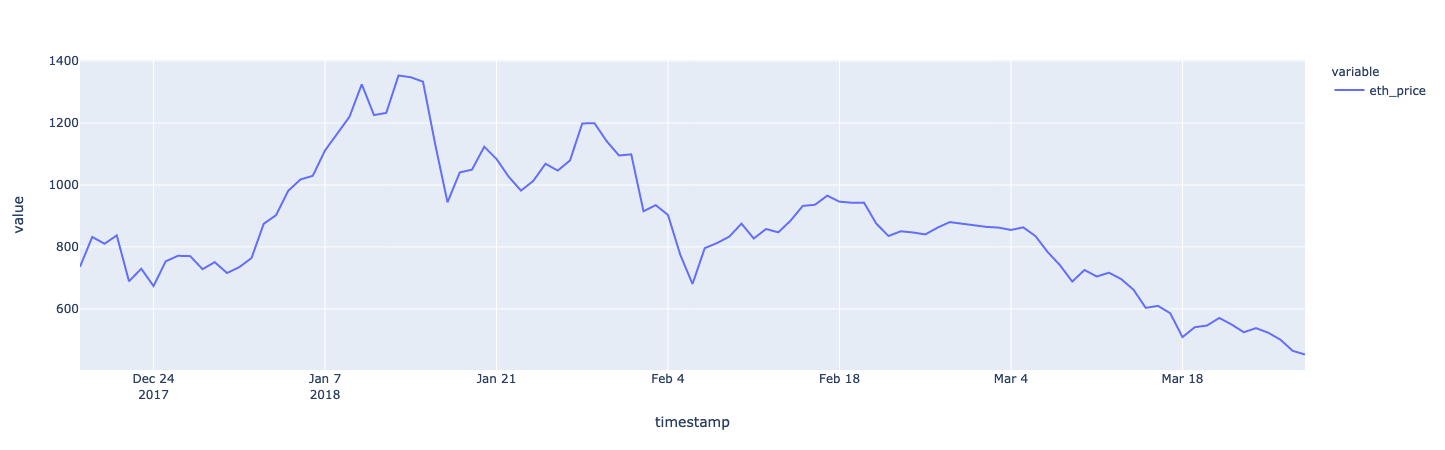

In [25]:
simulation_result.plot(x='timestamp', y=['eth_price'])

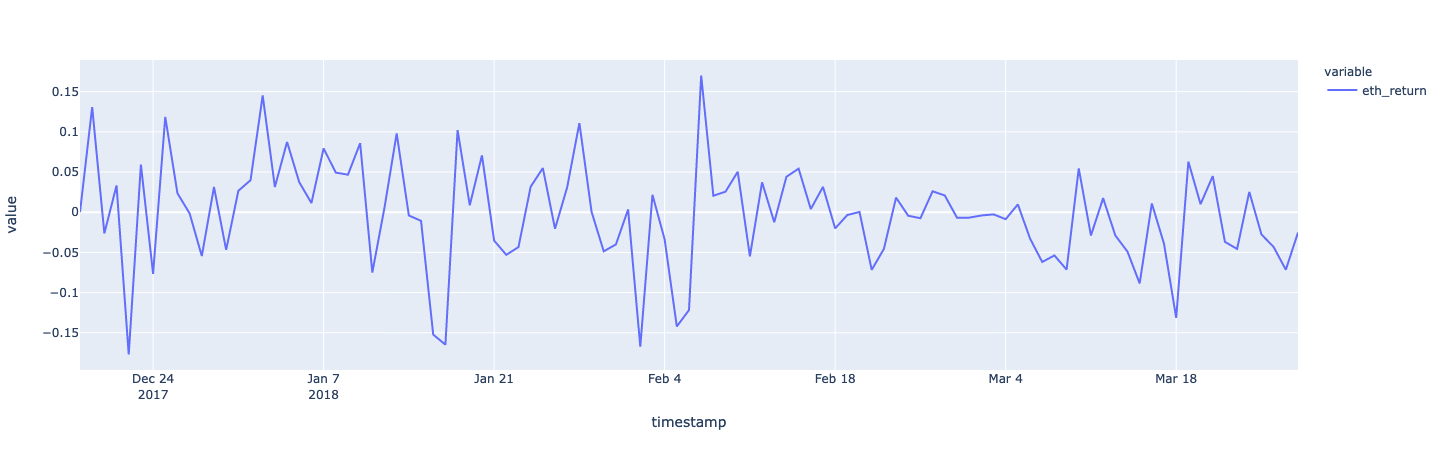

In [26]:
simulation_result.plot(x='timestamp', y=['eth_return'])

## Target price / redemption price set to 1 "dollar" for historical comparison

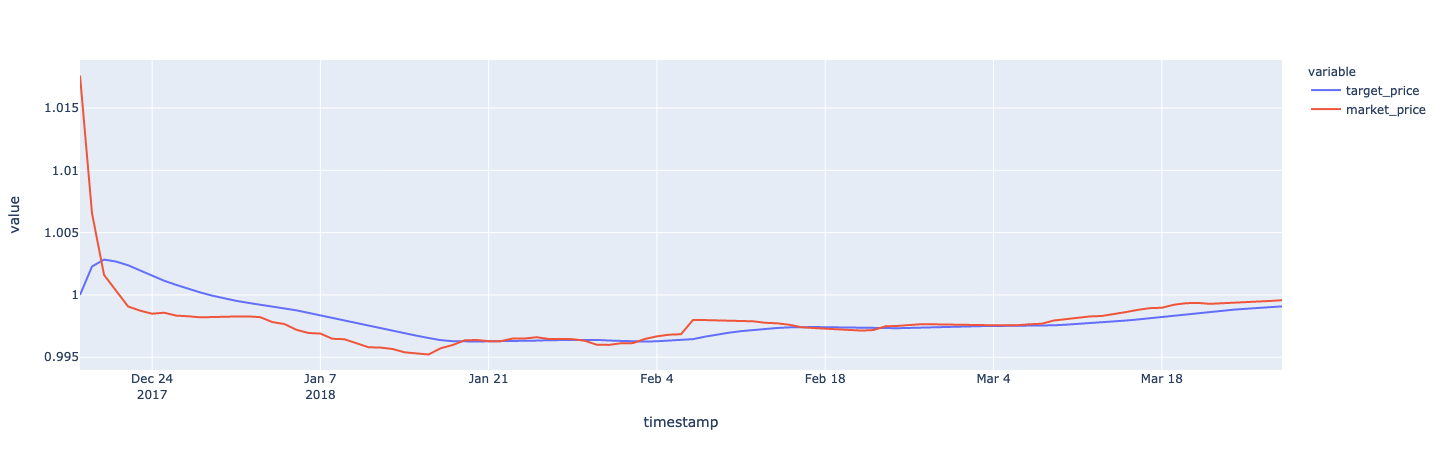

In [27]:
simulation_result.plot(x='timestamp', y=['target_price', 'market_price'])

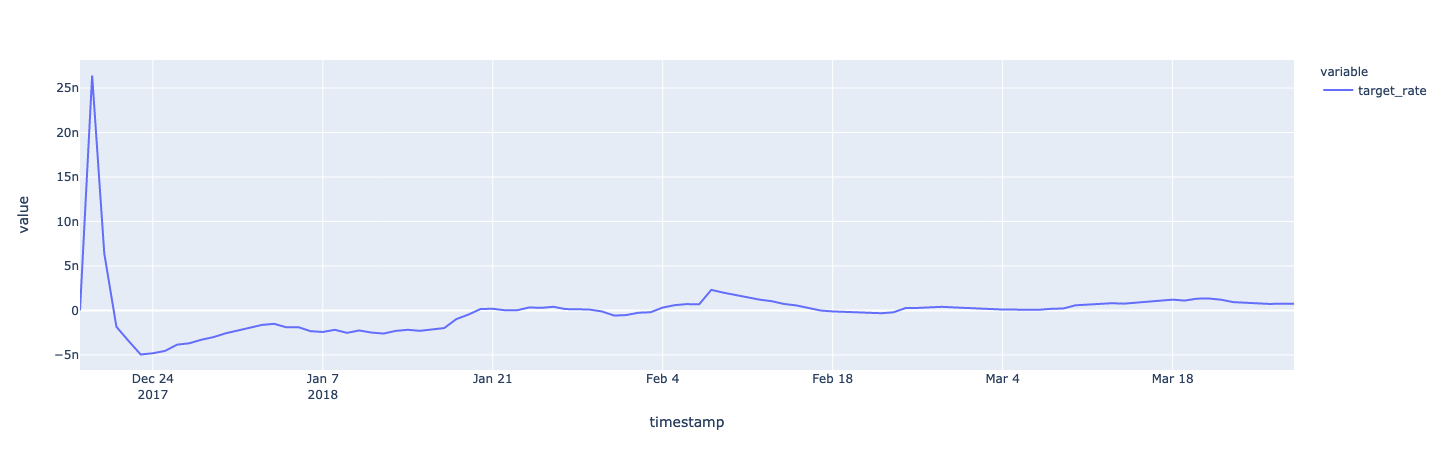

In [28]:
simulation_result.plot(x='timestamp', y=['target_rate'])

## Historical system ETH collateral vs. model

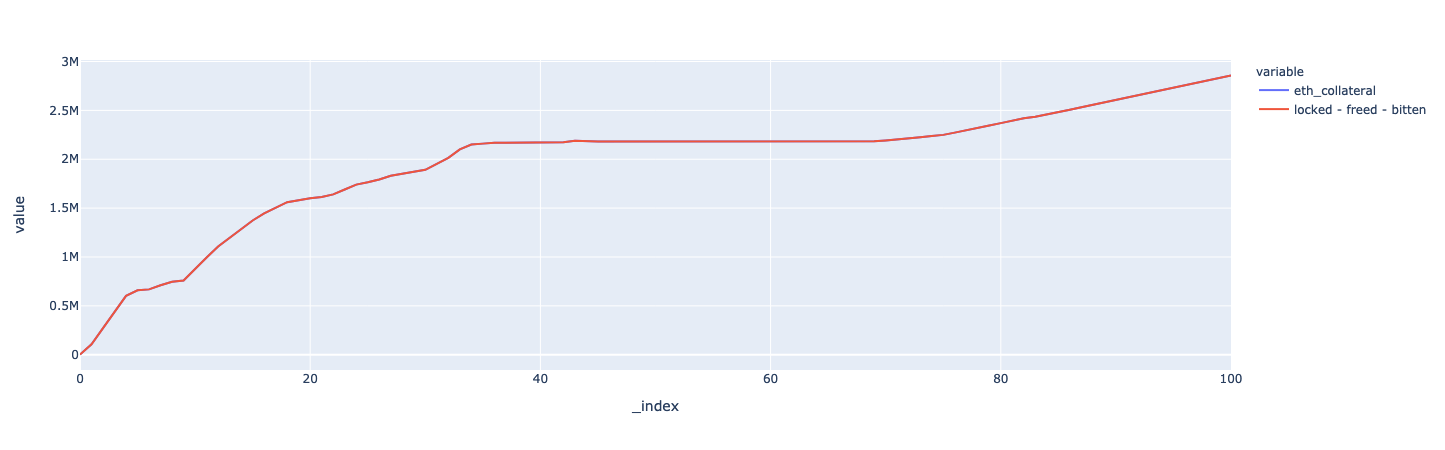

In [29]:
simulation_result['locked - freed - bitten'] = simulation_result['eth_locked'] - simulation_result['eth_freed'] - simulation_result['eth_bitten']
simulation_result.plot(y=['eth_collateral', 'locked - freed - bitten']) #'Q'

## Historical system ETH collateral value vs. model

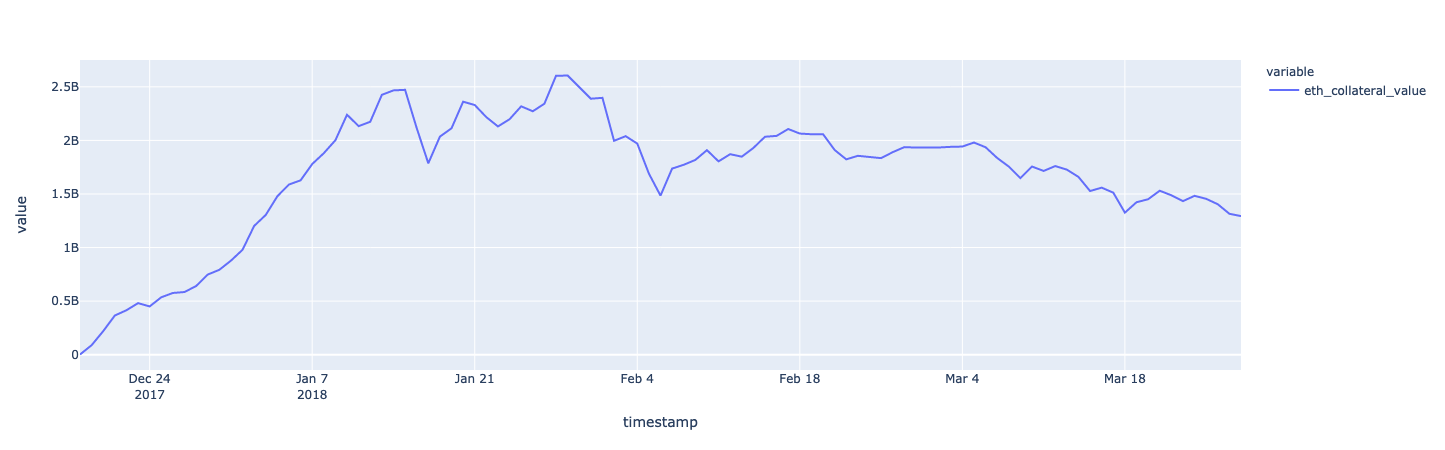

In [30]:
simulation_result.plot(x='timestamp', y=['eth_collateral_value']) #'C_star'

## Debt market ETH activity

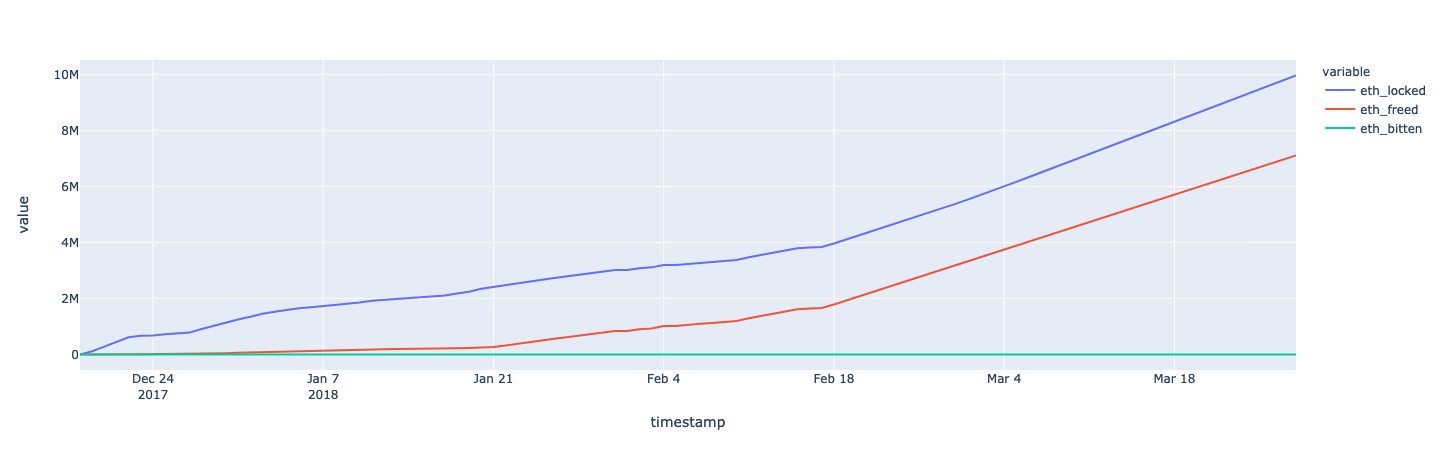

In [31]:
simulation_result.plot(x='timestamp', y=['eth_locked', 'eth_freed', 'eth_bitten'])

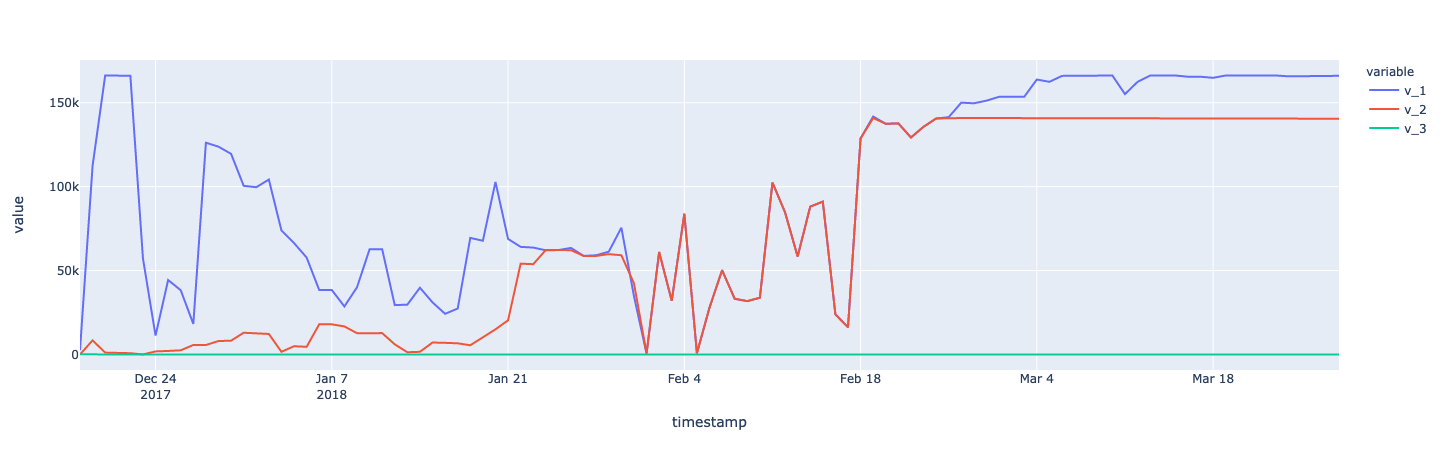

In [32]:
simulation_result.plot(x='timestamp', y=['v_1', 'v_2', 'v_3'])

## Debt market principal debt "Rai" activity

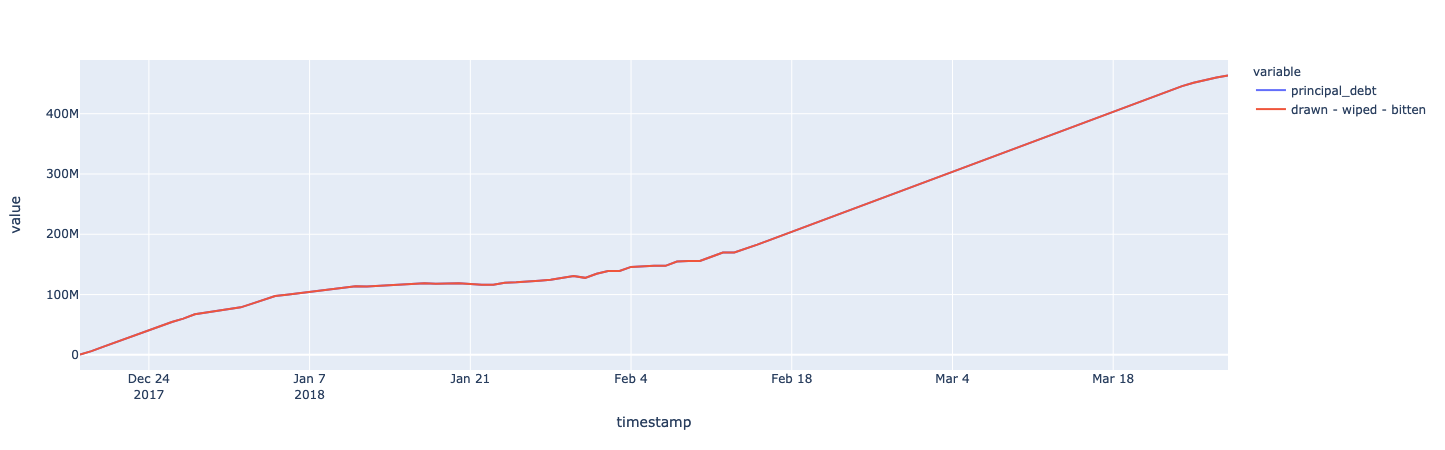

In [33]:
simulation_result['drawn - wiped - bitten'] = simulation_result['rai_drawn'] - simulation_result['rai_wiped'] - simulation_result['rai_bitten']
simulation_result.plot(x='timestamp', y=['principal_debt', 'drawn - wiped - bitten']) #, 'D_1'

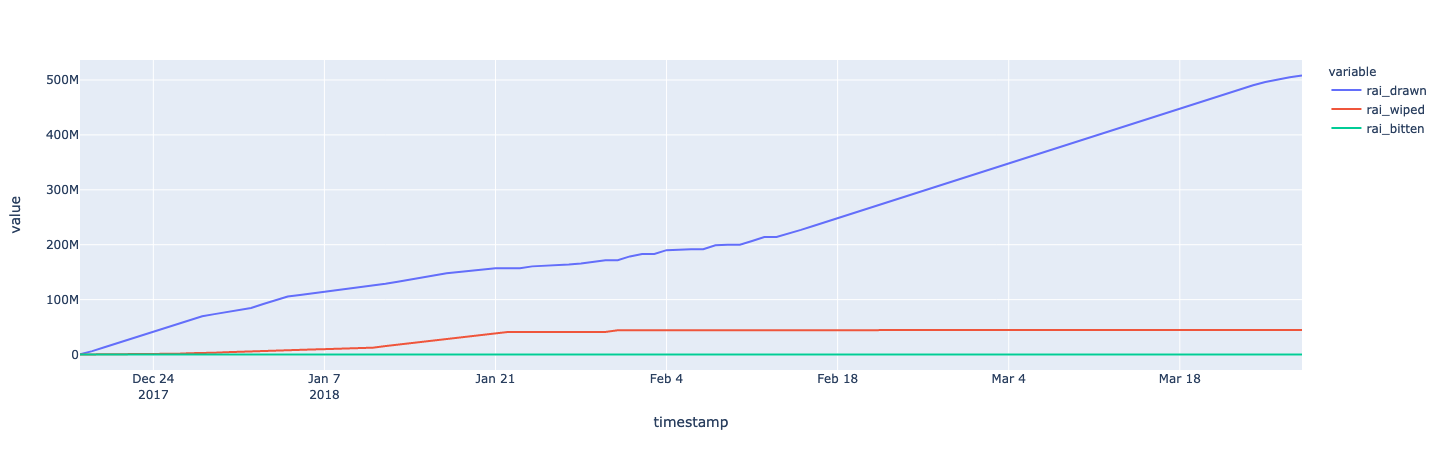

In [34]:
simulation_result.plot(x='timestamp', y=['rai_drawn', 'rai_wiped', 'rai_bitten'])

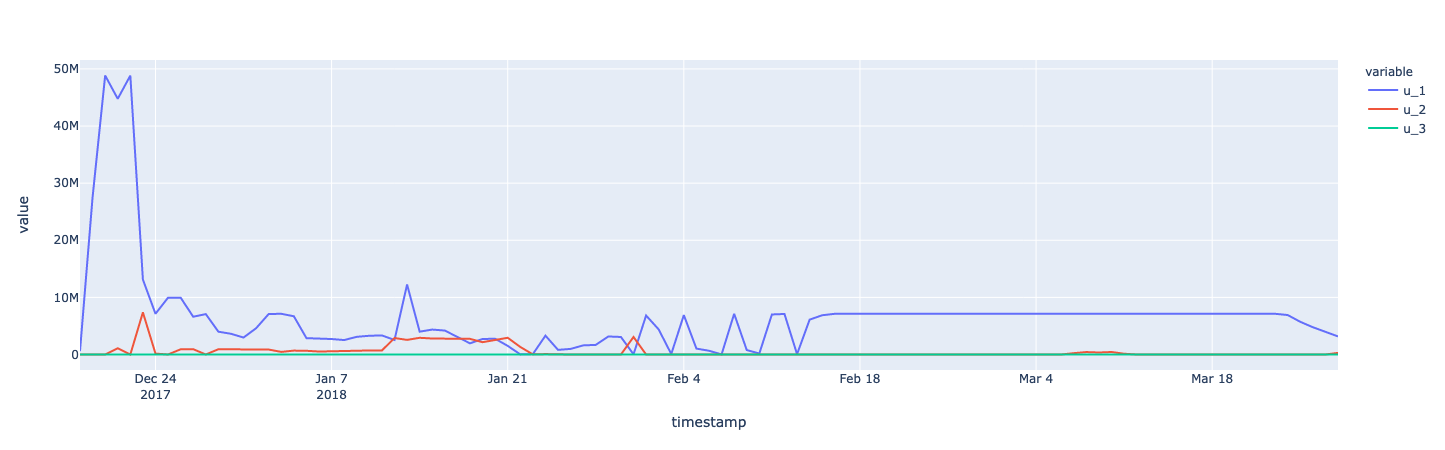

In [35]:
simulation_result.plot(x='timestamp', y=['u_1', 'u_2', 'u_3'])

## Accrued interest and system revenue (MKR)

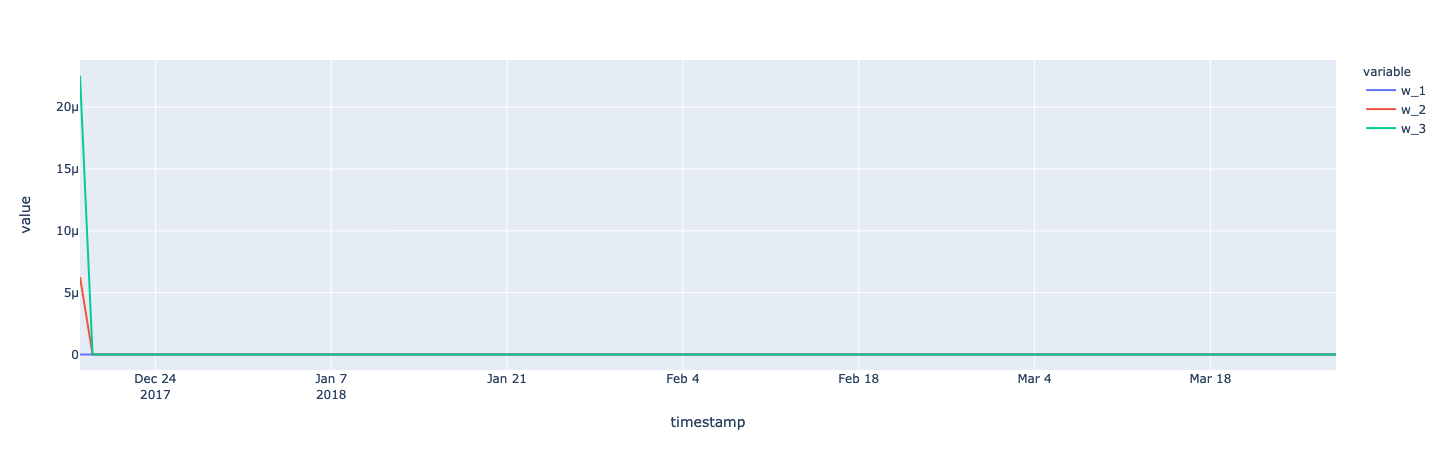

In [36]:
simulation_result.plot(x='timestamp', y=['w_1', 'w_2', 'w_3'])

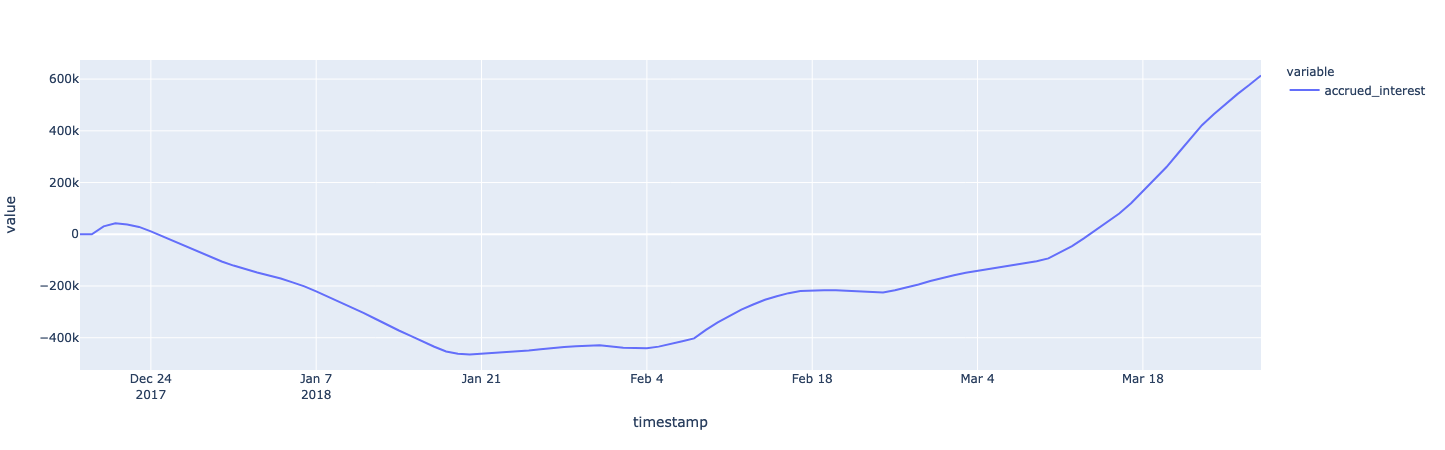

In [37]:
simulation_result.plot(x='timestamp', y=['accrued_interest']) #, 'D_2'

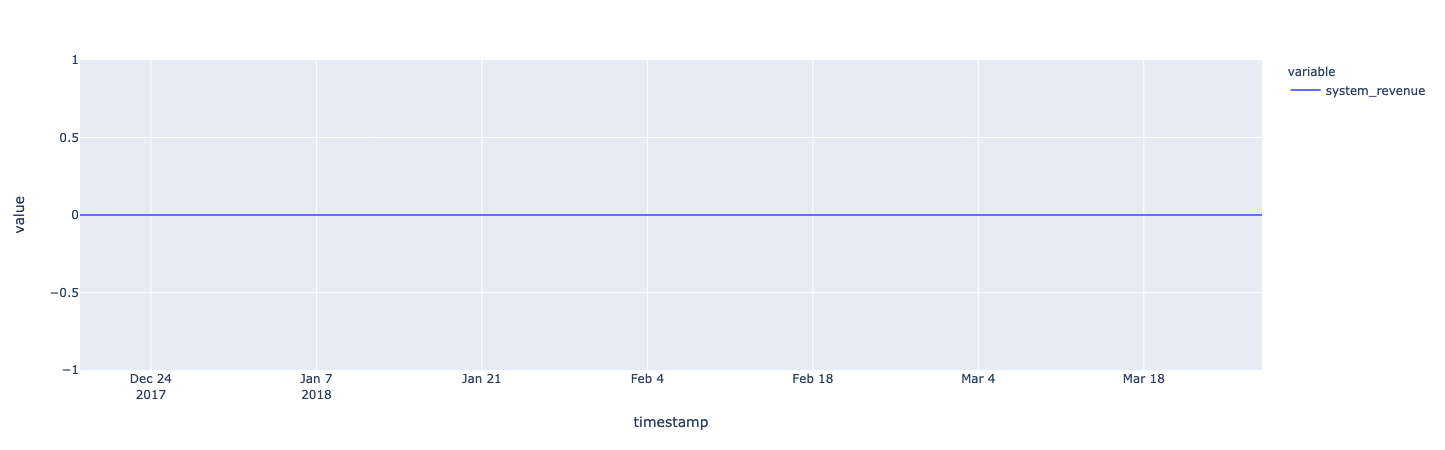

In [38]:
simulation_result.plot(x='timestamp', y=['system_revenue'])

## Historical collateralization ratio vs. model

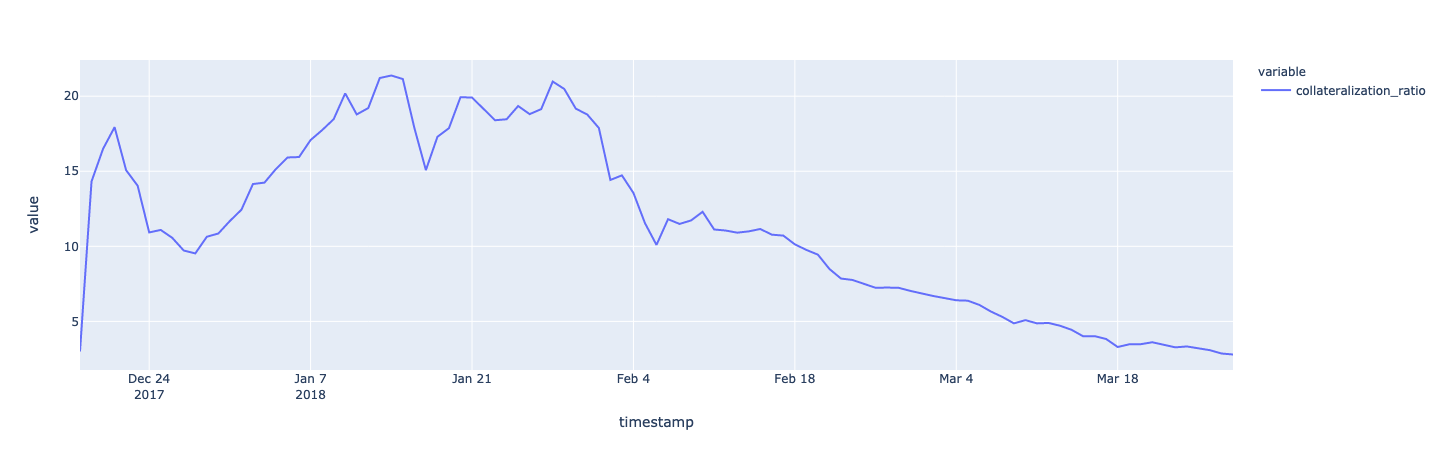

In [39]:
simulation_result.plot(x='timestamp', y=['collateralization_ratio']) #, 'historical_collateralization_ratio'